In [3]:
import pandas as pd

import torch
from torch import nn

import os
import sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)

from utils import *
from model import SpatialModel

In [4]:
df = pd.read_csv('oto_points.csv')

In [5]:
smoothing = .001

dist_df = df.filter(regex=".*_closest").apply(lambda x: 1 / (x + smoothing)).fillna(0)

In [6]:
num_df = df.drop(columns=["address", *dist_df.columns.tolist()])

In [7]:
data = pd.concat((num_df, dist_df), axis=1)

In [8]:
train_data, test_data = split_data(data)
x_train = train_data.drop(columns='price')
y_train = train_data['price']
x_test = test_data.drop(columns='price')
y_test = test_data['price']

train_dl, test_dl = to_dataloaders(x_train, y_train, x_test, y_test)

In [55]:
from torchmetrics import R2Score

loss_fn = nn.L1Loss()
score_fn = R2Score()

In [70]:
from tqdm import tqdm
import numpy as np

sizes = [2**k for k in range(5, 10)]
base_model = SpatialModel(*sizes[:-1], *sizes[::-1])
optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-3)

epochs = 50
losses = list()
scores = list()

losses_test = list()
scores_test = list()

In [71]:
for _ in tqdm(range(epochs)):
    epoch_loss = list()
    epoch_score = list()
    base_model.train()
    for x, y in train_dl:
        optimizer.zero_grad()
        y_pred = base_model(x).flatten()
        
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        epoch_score.append(score_fn(y_pred, y).item())
        
    losses.append(np.mean(epoch_loss))
    scores.append(np.mean(epoch_score))
    
    epoch_loss = list()
    epoch_score = list()
    base_model.eval()
    with torch.no_grad():
        for x, y in test_dl:
            y_pred = base_model(x).flatten()
            loss = loss_fn(y_pred, y)        
            epoch_loss.append(loss.item())
            epoch_score.append(score_fn(y_pred, y).item())
        
    losses_test.append(np.mean(epoch_loss))
    scores_test.append(np.mean(epoch_score))

100%|██████████| 50/50 [04:23<00:00,  5.27s/it]


/var/folders/nm/kl8l86m164dfl1nn3zn_crpm0000gp/T/ipykernel_27316/1021500129.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('loss.png')
/var/folders/nm/kl8l86m164dfl1nn3zn_crpm0000gp/T/ipykernel_27316/1021500129.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('loss.png')
/var/folders/nm/kl8l86m164dfl1nn3zn_crpm0000gp/T/ipykernel_27316/1021500129.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('loss.png')
/var/folders/nm/kl8l86m164dfl1nn3zn_crpm0000gp/T/ipykernel_27316/1021500129.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientat

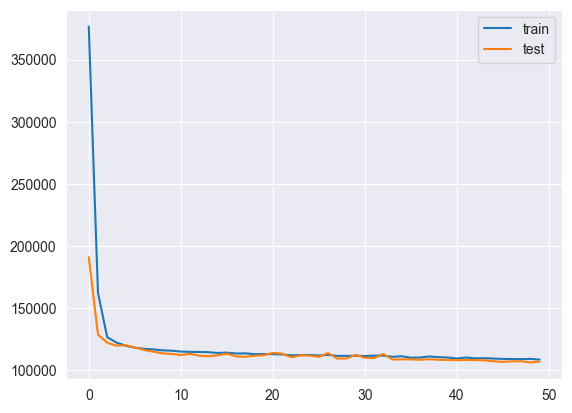

In [76]:
import matplotlib.pyplot as plt

plt.plot(losses, label='train')
plt.plot(losses_test, label='test')
plt.legend()
plt.savefig('loss.png')

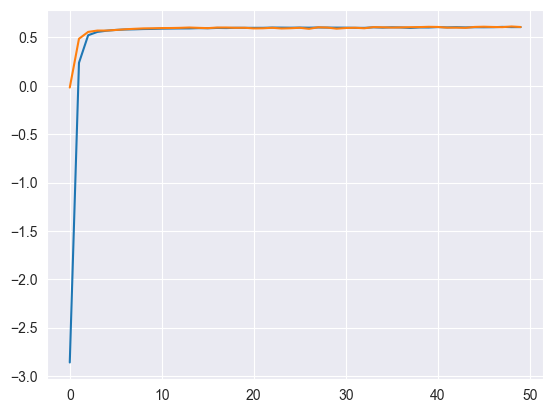

In [73]:
plt.plot(scores, label='train')
plt.plot(scores_test, label='test')

In [ ]:
torch.save(base_model.state_dict(), 'log_model.pt')